# Program 9

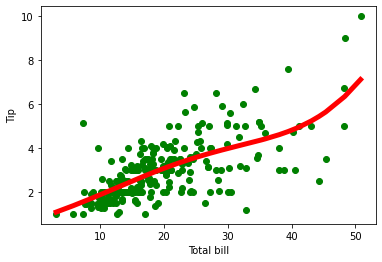

In [3]:


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def kernel(point,xmat, k):
    m,n = np.shape(xmat)
    weights = np.mat(np.eye((m))) # eye - identity matrix
    for j in range(m):
        diff = point - X[j]
        weights[j,j] = np.exp(diff*diff.T/(-2.0*k**2))
    return weights

def localWeight(point,xmat,ymat,k):
    wei = kernel(point,xmat,k)
    W = (X.T*(wei*X)).I*(X.T*(wei*ymat.T))
    return W


def localWeightRegression(xmat,ymat,k):
    m,n = np.shape(xmat)
    ypred = np.zeros(m)
    for i in range(m):
        ypred[i] = xmat[i]*localWeight(xmat[i],xmat,ymat,k)
    return ypred

def graphPlot(X,ypred):
    sortindex = X[:,1].argsort(0) 
    xsort = X[sortindex][:,0]
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(bill,tip, color='green')
    ax.plot(xsort[:,1],ypred[sortindex], color = 'red', linewidth=5)
    plt.xlabel('Total bill')
    plt.ylabel('Tip')
    plt.show()
    

data = pd.read_csv('10data_tips.csv')
bill = np.array(data.total_bill) # We use only Bill amount and Tips data
tip = np.array(data.tip)
mbill = np.mat(bill) # .mat will convert nd array is converted in 2D array
mtip = np.mat(tip)
m= np.shape(mbill)[1]
one = np.mat(np.ones(m))
X = np.hstack((one.T,mbill.T)) # 244 rows, 2 cols
ypred = localWeightRegression(X,mtip,8) # increase k to get smooth curves
graphPlot(X,ypred)


# Program 7

Observation: The GMM using EM algorithm based clustering matched the true labels more closely than the Kmeans.


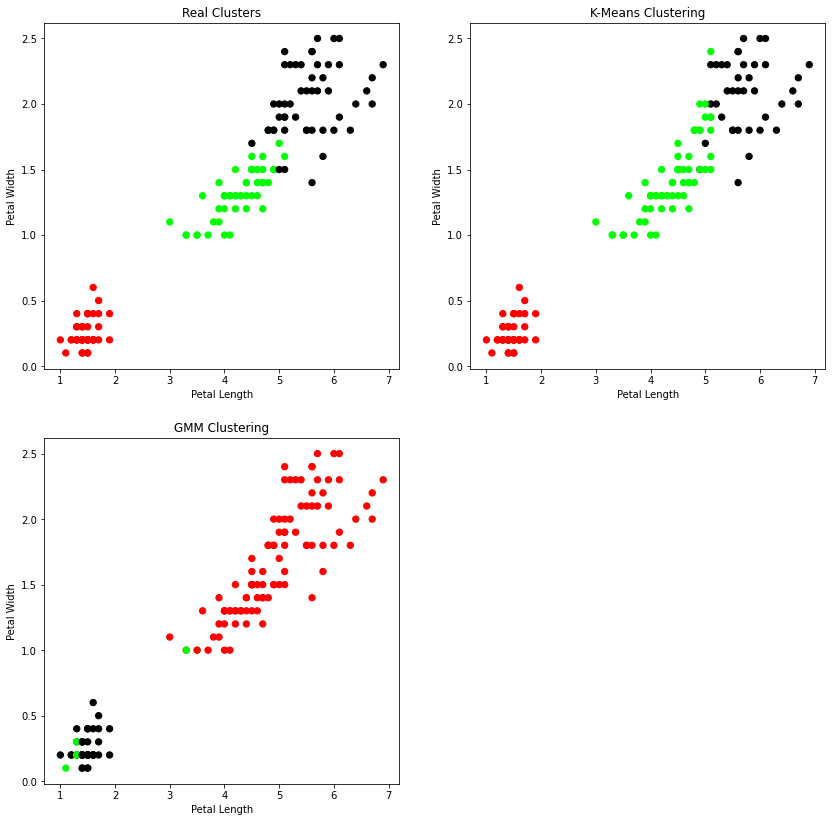

In [3]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

iris = datasets.load_iris()
X = pd.DataFrame(iris.data)
X.columns = ['Sepal_Length','Sepal_Width','Petal_Length','Petal_Width']
y = pd.DataFrame(iris.target)
y.columns = ['Targets']

 # Build the K Means Model
model = KMeans(n_clusters=3)
model.fit(X) # model.labels_ : Gives cluster no for which samples belongs to

 # # Visualise the clustering results
plt.figure(figsize=(14,14))
colormap = np.array(['red', 'lime', 'black'])
 # Plot the Original Classifications using Petal features
plt.subplot(2, 2, 1)
plt.scatter(X.Petal_Length, X.Petal_Width, c=colormap[y.Targets], s=40)
plt.title('Real Clusters')
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
 # Plot the Models Classifications
plt.subplot(2, 2, 2)
plt.scatter(X.Petal_Length, X.Petal_Width, c=colormap[model.labels_], s=40)
plt.title('K-Means Clustering')
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')

 # General EM for GMM
from sklearn import preprocessing
 # transform your data such that its distribution will have a
 # mean value 0 and standard deviation of 1.
scaler = preprocessing.StandardScaler()
scaler.fit(X)
xsa = scaler.transform(X)
xs = pd.DataFrame(xsa, columns = X.columns)

from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3)
gmm.fit(xs)
gmm_y = gmm.predict(xs)


plt.subplot(2, 2, 3)
plt.scatter(X.Petal_Length, X.Petal_Width, c=colormap[gmm_y], s=40)
plt.title('GMM Clustering')
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')

print('Observation: The GMM using EM algorithm based clustering matched the true labels more closely than the Kmeans.')


# Program 6

In [12]:
import csv
import random
import math
def safe_div(x,y):
    if y == 0:
        return 0
    return x / y
def loadCsv(filename):
    lines = csv.reader(open(filename, "r"))
    dataset = list(lines)
    for i in range(len(dataset)):
		dataset[i] = [float(x) for x in dataset[i]]
	return dataset

def splitDataset(dataset, splitRatio):
	trainSize = int(len(dataset) * splitRatio)
	trainSet = []
	copy = list(dataset)
	while len(trainSet) < trainSize:
		index = random.randrange(len(copy))
		trainSet.append(copy.pop(index))
	return [trainSet, copy]

def separateByClass(dataset):
    separated = {}
    for i in range(len(dataset)):
		vector = dataset[i]
		if (vector[-1] not in separated):
            separated[vector[-1]] = []
		separated[vector[-1]].append(vector)

	return separated

def mean(numbers):
	return sum(numbers)/float(len(numbers))

def stdev(numbers):
	avg = mean(numbers)
	variance = sum([pow(x-avg,2) for x in numbers])/float(len(numbers)-1)
	return math.sqrt(variance)

def summarize(dataset):
	summaries = [(mean(attribute), stdev(attribute)) for attribute in zip(*dataset)]
	del summaries[-1]
	return summaries

def summarizeByClass(dataset):
	separated = separateByClass(dataset)
	summaries = {}
	for classValue, instances in separated.items():
		summaries[classValue] = summarize(instances)
	return summaries

def calculateProbability(x, mean, stdev):
	exponent = math.exp(-(math.pow(x-mean,2)/(2*math.pow(stdev,2))))
	return (1 / (math.sqrt(2*math.pi) * stdev)) * exponent

def calculateClassProbabilities(summaries, inputVector):
	probabilities = {}
	for classValue, classSummaries in summaries.items():
		probabilities[classValue] = 1
		for i in range(len(classSummaries)):
			mean, stdev = classSummaries[i]
			x = inputVector[i]
			probabilities[classValue] *= calculateProbability(x, mean, stdev)
	return probabilities
			
def predict(summaries, inputVector):
	probabilities = calculateClassProbabilities(summaries, inputVector)
	bestLabel, bestProb = None, -1
	for classValue, probability in probabilities.items():
		if bestLabel is None or probability > bestProb:
			bestProb = probability
			bestLabel = classValue
	return bestLabel

def getPredictions(summaries, testSet):
	predictions = []
	for i in range(len(testSet)):
		result = predict(summaries, testSet[i])
		predictions.append(result)

	return predictions

def getAccuracy(testSet, predictions):
    correct = 0
    for i in range(len(testSet)):
        #print(testSet[i][-1]," ",predictions[i])
        if testSet[i][-1] == predictions[i]:
            correct += 1

        return (correct/float(len(testSet))) * 100.0

def main():
	filename = 'pima-indians-diabetes.data.csv'
	splitRatio = 0.67
	dataset = loadCsv(filename)
	trainingSet,testSet=splitDataset(dataset, splitRatio) #dividing into training and test data
	#trainingSet = dataset #passing entire dataset as training data
	#testSet=[[8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0]]
	print('Split {0} rows into train={1} and test={2} rows'.format(len(dataset), len(trainingSet), len(testSet)))
	# prepare model
	summaries = summarizeByClass(trainingSet)
	# test model
	predictions = getPredictions(summaries, testSet)
	accuracy = getAccuracy(testSet, predictions)
	print('Accuracy: {0}%'.format(accuracy))

main()


Split 768 rows into train=514 and test=254 rows
Accuracy: 0.39370078740157477%


# Program 3

In [4]:
import numpy as np
import pandas as pd

data = pd.DataFrame(data=pd.read_csv('1finds.csv'))
concepts = np.array(data.iloc[:,0:-1])
target = np.array(data.iloc[:,-1])

def learn(concepts, target):
    specific_h = concepts[0].copy()
    general_h = [["?" for i in range(len(specific_h))] for i in range(len(specific_h))]
   
    for i, h in enumerate(concepts):
        
        if target[i] == "Yes":
            for x in range(len(specific_h)):
                if h[x] != specific_h[x]:
                    specific_h[x] = '?'
                    general_h[x][x] = '?'
                        
        if target[i] == "No":
            for x in range(len(specific_h)):             
                if h[x] != specific_h[x]:
                    general_h[x][x] = specific_h[x]
                else:
                    general_h[x][x] = '?'
    
    
    indices = [i for i,val in enumerate(general_h) if val == ['?', '?', '?', '?', '?', '?']]
    for i in indices:
        
        general_h.remove(['?', '?', '?', '?', '?', '?'])
    return specific_h, general_h
s_final, g_final = learn(concepts, target)
print("Final S:", s_final, sep="\n")
print("Final G:", g_final, sep="\n")


Final S:
['Sunny' 'Warm' '?' 'Strong' '?' '?']
Final G:
[['Sunny', '?', '?', '?', '?', '?'], ['?', 'Warm', '?', '?', '?', '?']]


# Program 1

In [3]:
def aStarAlgo(start_node, stop_node):
         
        open_set = set(start_node) 
        closed_set = set()
        g = {} #store distance from starting node
        parents = {}# parents contains an adjacency map of all nodes
 
        #ditance of starting node from itself is zero
        g[start_node] = 0
        #start_node is root node i.e it has no parent nodes
        #so start_node is set to its own parent node
        parents[start_node] = start_node
         
         
        while len(open_set) > 0:
            n = None
 
            #node with lowest f() is found
            for v in open_set:
                if n == None or g[v] + heuristic(v) < g[n] + heuristic(n):
                    n = v
             
                     
            if n == stop_node or Graph_nodes[n] == None:
                pass
            else:
                for (m, weight) in get_neighbors(n):
                   #nodes 'm' not in first and last set are added to first
                    #n is set its parent
                    if m not in open_set and m not in closed_set:
                        open_set.add(m)
                        parents[m] = n
                        g[m] = g[n] + weight
                         
     
                    #for each node m,compare its distance from start i.e g(m) to the
                    #from start through n node
                    else:
                        if g[m] > g[n] + weight:
                            #update g(m)
                            g[m] = g[n] + weight
                            #change parent of m to n
                            parents[m] = n
                             
                            #if m in closed set,remove and add to open
                            if m in closed_set:
                                closed_set.remove(m)
                                open_set.add(m)
 
            if n == None:
                print('Path does not exist!')
                return None
 
            # if the current node is the stop_node
            # then we begin reconstructin the path from it to the start_node
            if n == stop_node:
                path = []
 
                while parents[n] != n:
                    path.append(n)
                    n = parents[n]
 
                path.append(start_node)
 
                path.reverse()
 
                print('Path found: {}'.format(path))
                return path
 
 
            # remove n from the open_list, and add it to closed_list
            # because all of his neighbors were inspected
            open_set.remove(n)
            closed_set.add(n)
 
        print('Path does not exist!')
        return None
         
#define fuction to return neighbor and its distance
#from the passed node
def get_neighbors(v):
    if v in Graph_nodes:
        return Graph_nodes[v]
    else:
        return None
#for simplicity we ll consider heuristic distances given
#and this function returns heuristic distance for all nodes
def heuristic(n):
        H_dist = {
            'A': 10,
            'B': 8,
            'C': 5,
            'D': 7,
            'E': 3,
            'F': 6,
            'G': 5,
            'H': 3,
            'I': 1,
            'J': 0             
        }
 
        return H_dist[n]
 
#Describe your graph here  
Graph_nodes = {
    'A': [('B', 6), ('F', 3)],
    'B': [('C', 3), ('D', 2)],
    'C': [('D', 1), ('E', 5)],
    'D': [('C', 1), ('E', 8)],
    'E': [('I', 5), ('J', 5)],
    'F': [('G', 1),('H', 7)] ,
    'G': [('I', 3)],
    'H': [('I', 2)],
    'I': [('E', 5), ('J', 3)],
     
}
aStarAlgo('A', 'J')


Path found: ['A', 'F', 'G', 'I', 'J']


['A', 'F', 'G', 'I', 'J']

# Program 2

In [1]:
class Graph:
    def __init__(self, graph, heuristicNodeList, startNode):  
        
        self.graph = graph
        self.H=heuristicNodeList
        self.start=startNode
        self.parent={}
        self.status={}
        self.solutionGraph={}
     
    def applyAOStar(self):        
        self.aoStar(self.start, False)

    def getNeighbors(self, v):     
        return self.graph.get(v,'')
    
    def getStatus(self,v):         
        return self.status.get(v,0) 
    
    def setStatus(self,v, val):   
        self.status[v]=val
    
    def getHeuristicNodeValue(self, n):
        return self.H.get(n,0)     
 
    def setHeuristicNodeValue(self, n, value):
        self.H[n]=value           
        
    
    def printSolution(self):
        print("FOR GRAPH SOLUTION, TRAVERSE THE GRAPH FROM THE START NODE:",self.start)
        print("------------------------------------------------------------")
        print(self.solutionGraph)
        print("------------------------------------------------------------")
    
    def computeMinimumCostChildNodes(self, v):  # Computes the Minimum Cost of child nodes of a given node v     
        minimumCost=0
        costToChildNodeListDict={}
        costToChildNodeListDict[minimumCost]=[]
        flag=True
        for nodeInfoTupleList in self.getNeighbors(v):  # iterate over all the set of child node/s
            cost=0
            nodeList=[]
            for c, weight in nodeInfoTupleList:
                cost=cost+self.getHeuristicNodeValue(c)+weight
                nodeList.append(c)
            
            if flag==True:                      # initialize Minimum Cost with the cost of first set of child node/s 
                minimumCost=cost
                costToChildNodeListDict[minimumCost]=nodeList      # set the Minimum Cost child node/s
                flag=False
            else:                               # checking the Minimum Cost nodes with the current Minimum Cost   
                if minimumCost>cost:
                    minimumCost=cost
                    costToChildNodeListDict[minimumCost]=nodeList  # set the Minimum Cost child node/s
                
              
        return minimumCost, costToChildNodeListDict[minimumCost]   # return Minimum Cost and Minimum Cost child node/s
                     
    
    def aoStar(self, v, backTracking):     # AO* algorithm for a start node and backTracking status flag
        
        print("HEURISTIC VALUES  :", self.H)
        print("SOLUTION GRAPH    :", self.solutionGraph)
        print("PROCESSING NODE   :", v)
        print("-----------------------------------------------------------------------------------------")
        
        if self.getStatus(v) >= 0:        # if status node v >= 0, compute Minimum Cost nodes of v
            minimumCost, childNodeList = self.computeMinimumCostChildNodes(v)
            self.setHeuristicNodeValue(v, minimumCost)
            self.setStatus(v,len(childNodeList))
            
            solved=True                   # check the Minimum Cost nodes of v are solved   
            for childNode in childNodeList:
                self.parent[childNode]=v
                if self.getStatus(childNode)!=-1:
                    solved=solved & False
            
            if solved==True:             # if the Minimum Cost nodes of v are solved, set the current node status as solved(-1)
                self.setStatus(v,-1)    
                self.solutionGraph[v]=childNodeList # update the solution graph with the solved nodes which may be a part of solution  
            
            
            if v!=self.start:           # check the current node is the start node for backtracking the current node value    
                self.aoStar(self.parent[v], True)   # backtracking the current node value with backtracking status set to true
                
            if backTracking==False:     # check the current call is not for backtracking 
                for childNode in childNodeList:   # for each Minimum Cost child node
                    self.setStatus(childNode,0)   # set the status of child node to 0(needs exploration)
                    self.aoStar(childNode, False) # Minimum Cost child node is further explored with backtracking status as false
                 
        
                                       
h1 = {'A': 1, 'B': 6, 'C': 2, 'D': 12, 'E': 2, 'F': 1, 'G': 5, 'H': 7, 'I': 7, 'J': 1, 'T': 3}
graph1 = {
    'A': [[('B', 1), ('C', 1)], [('D', 1)]],
    'B': [[('G', 1)], [('H', 1)]],
    'C': [[('J', 1)]],
    'D': [[('E', 1), ('F', 1)]],
    'G': [[('I', 1)]]   
}
G1= Graph(graph1, h1, 'A')
G1.applyAOStar() 
G1.printSolution()

h2 = {'A': 1, 'B': 6, 'C': 12, 'D': 10, 'E': 4, 'F': 4, 'G': 5, 'H': 7}  # Heuristic values of Nodes 
graph2 = {                                        # Graph of Nodes and Edges 
    'A': [[('B', 1), ('C', 1)], [('D', 1)]],      # Neighbors of Node 'A', B, C & D with repective weights 
    'B': [[('G', 1)], [('H', 1)]],                # Neighbors are included in a list of lists
    'D': [[('E', 1), ('F', 1)]]                   # Each sublist indicate a "OR" node or "AND" nodes
}

G2 = Graph(graph2, h2, 'A')                       # Instantiate Graph object with graph, heuristic values and start Node
G2.applyAOStar()                                  # Run the AO* algorithm
G2.printSolution()                                # Print the solution graph as output of the AO* algorithm search


HEURISTIC VALUES  : {'A': 1, 'B': 6, 'C': 2, 'D': 12, 'E': 2, 'F': 1, 'G': 5, 'H': 7, 'I': 7, 'J': 1, 'T': 3}
SOLUTION GRAPH    : {}
PROCESSING NODE   : A
-----------------------------------------------------------------------------------------
HEURISTIC VALUES  : {'A': 10, 'B': 6, 'C': 2, 'D': 12, 'E': 2, 'F': 1, 'G': 5, 'H': 7, 'I': 7, 'J': 1, 'T': 3}
SOLUTION GRAPH    : {}
PROCESSING NODE   : B
-----------------------------------------------------------------------------------------
HEURISTIC VALUES  : {'A': 10, 'B': 6, 'C': 2, 'D': 12, 'E': 2, 'F': 1, 'G': 5, 'H': 7, 'I': 7, 'J': 1, 'T': 3}
SOLUTION GRAPH    : {}
PROCESSING NODE   : A
-----------------------------------------------------------------------------------------
HEURISTIC VALUES  : {'A': 10, 'B': 6, 'C': 2, 'D': 12, 'E': 2, 'F': 1, 'G': 5, 'H': 7, 'I': 7, 'J': 1, 'T': 3}
SOLUTION GRAPH    : {}
PROCESSING NODE   : G
-----------------------------------------------------------------------------------------
HEURISTIC VALUES 

# Program 8

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.datasets import load_iris
data = load_iris() 
df = pd.DataFrame(data.data, columns=data.feature_names) 
df['Class'] = data.target_names[data.target] 

x = df.iloc[:, :-1].values 
y = df.Class.values

from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
from sklearn.neighbors import KNeighborsClassifier 
knn_classifier = KNeighborsClassifier(n_neighbors=5) 
knn_classifier.fit(x_train, y_train)
predictions = knn_classifier.predict(x_test) 
print(predictions)
from sklearn.metrics import accuracy_score, confusion_matrix 
print("Training accuracy Score is : ", accuracy_score(y_train, knn_classifier.predict(x_train))) 
print("Testing accuracy Score is : ", accuracy_score(y_test, knn_classifier.predict(x_test)))
print("Training Confusion Matrix is : \n", confusion_matrix(y_train, knn_classifier.predict(x_train))) 
print("Testing Confusion Matrix is : \n", confusion_matrix(y_test, knn_classifier.predict(x_test)))


['versicolor' 'setosa' 'versicolor' 'setosa' 'versicolor' 'virginica'
 'setosa' 'versicolor' 'virginica' 'virginica' 'setosa' 'versicolor'
 'virginica' 'virginica' 'versicolor' 'versicolor' 'virginica' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor' 'versicolor' 'setosa'
 'virginica' 'versicolor' 'setosa' 'virginica' 'virginica' 'versicolor']
Training accuracy Score is :  0.9583333333333334
Testing accuracy Score is :  0.9666666666666667
Training Confusion Matrix is : 
 [[43  0  0]
 [ 0 36  2]
 [ 0  3 36]]
Testing Confusion Matrix is : 
 [[ 7  0  0]
 [ 0 12  0]
 [ 0  1 10]]


# Program 5

In [2]:
from math import exp
from random import seed
from random import random
 
# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs):
    network = list()
	hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
	network.append(hidden_layer)
	output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
	network.append(output_layer)
	return network
 
# Calculate neuron activation for an input
def activate(weights, inputs):
	activation = weights[-1]
	for i in range(len(weights)-1):
		activation += weights[i] * inputs[i]
	return activation
 
# Transfer neuron activation
def transfer(activation):
	return 1.0 / (1.0 + exp(-activation))
 
# Forward propagate input to a network output
def forward_propagate(network, row):
	inputs = row
	for layer in network:
		new_inputs = []
		for neuron in layer:
			activation = activate(neuron['weights'], inputs)
			neuron['output'] = transfer(activation)
			new_inputs.append(neuron['output'])
		inputs = new_inputs
	return inputs
 
# Calculate the derivative of an neuron output
def transfer_derivative(output):
	return output * (1.0 - output)
 
# Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
	for i in reversed(range(len(network))):
		layer = network[i]
		errors = list()
		if i != len(network)-1:
			for j in range(len(layer)):
				error = 0.0
				for neuron in network[i + 1]:
					error += (neuron['weights'][j] * neuron['delta'])
				errors.append(error)
		else:
			for j in range(len(layer)):
				neuron = layer[j]
				errors.append(expected[j] - neuron['output'])
		for j in range(len(layer)):
			neuron = layer[j]
			neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])
 
# Update network weights with error
def update_weights(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[:-1]
		if i != 0:
			inputs = [neuron['output'] for neuron in network[i - 1]]
		for neuron in network[i]:
			for j in range(len(inputs)):
				neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
			neuron['weights'][-1] += l_rate * neuron['delta']
 
# Train a network for a fixed number of epochs
def train_network(network, train, l_rate, n_epoch, n_outputs):
	for epoch in range(n_epoch):
		sum_error = 0
		for row in train:
			outputs = forward_propagate(network, row)
			expected = [0 for i in range(n_outputs)]
			expected[row[-1]] = 1
			sum_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
			backward_propagate_error(network, expected)
			update_weights(network, row, l_rate)
		print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))
 
# Test training backprop algorithm
seed(1)

dataset = [[2.7810836,2.550537003,0],
	[1.465489372,2.362125076,0],
	[3.396561688,4.400293529,0],
	[1.38807019,1.850220317,0],
	[3.06407232,3.005305973,0],
	[7.627531214,2.759262235,1],
	[5.332441248,2.088626775,1],
	[6.922596716,1.77106367,1],
	[8.675418651,-0.242068655,1],
	[7.673756466,3.508563011,1]]
n_inputs = len(dataset[0]) - 1
n_outputs = len(set([row[-1] for row in dataset]))
network = initialize_network(n_inputs, 2, n_outputs)
print(network)
train_network(network, dataset, 0.5, 20, n_outputs)
for layer in network:
	print(layer)


[[{'weights': [0.13436424411240122, 0.8474337369372327, 0.763774618976614]}, {'weights': [0.2550690257394217, 0.49543508709194095, 0.4494910647887381]}], [{'weights': [0.651592972722763, 0.7887233511355132, 0.0938595867742349]}, {'weights': [0.02834747652200631, 0.8357651039198697, 0.43276706790505337]}]]
>epoch=0, lrate=0.500, error=6.350
>epoch=1, lrate=0.500, error=5.531
>epoch=2, lrate=0.500, error=5.221
>epoch=3, lrate=0.500, error=4.951
>epoch=4, lrate=0.500, error=4.519
>epoch=5, lrate=0.500, error=4.173
>epoch=6, lrate=0.500, error=3.835
>epoch=7, lrate=0.500, error=3.506
>epoch=8, lrate=0.500, error=3.192
>epoch=9, lrate=0.500, error=2.898
>epoch=10, lrate=0.500, error=2.626
>epoch=11, lrate=0.500, error=2.377
>epoch=12, lrate=0.500, error=2.153
>epoch=13, lrate=0.500, error=1.953
>epoch=14, lrate=0.500, error=1.774
>epoch=15, lrate=0.500, error=1.614
>epoch=16, lrate=0.500, error=1.472
>epoch=17, lrate=0.500, error=1.346
>epoch=18, lrate=0.500, error=1.233
>epoch=19, lrate=0.

# Program 4

In [1]:
import csv
import math
import random

# Majority Function which tells which class has more entries in given data-set
def majorClass(attributes, data, target):
    freq = {}
    index = attributes.index(target)
    for tuple in data:
        if tuple[index] in freq:
            freq[tuple[index]] += 1 
        else:
            freq[tuple[index]] = 1
    max = 0
    major = ""
    for key in freq.keys():
        if freq[key]>max:
            max = freq[key]
            major = key
    return major

# Calculates the entropy of the data given the target attribute
def entropy(attributes, data, targetAttr):
    freq = {}
    dataEntropy = 0.0
    i = 0
    for entry in attributes:
        if (targetAttr == entry):
            break
        i = i + 1
    i = i - 1
    for entry in data:
        if entry[i] in freq:
            freq[entry[i]] += 1.0
        else:
            freq[entry[i]]  = 1.0
    for freq in freq.values():
        dataEntropy += (-freq/len(data)) * math.log(freq/len(data), 2) 
    return dataEntropy

# Calculates the information gain (reduction in entropy) in the data when a particular attribute is chosen for splitting the data.
def info_gain(attributes, data, attr, targetAttr):
    freq = {}
    subsetEntropy = 0.0
    i = attributes.index(attr)
    for entry in data:
        if entry[i] in freq:
            freq[entry[i]] += 1.0
        else:
            freq[entry[i]]  = 1.0
    for val in freq.keys():
        valProb        = freq[val] / sum(freq.values())
        dataSubset     = [entry for entry in data if entry[i] == val]
        subsetEntropy += valProb * entropy(attributes, dataSubset, targetAttr)
    return (entropy(attributes, data, targetAttr) - subsetEntropy)

# This function chooses the attribute among the remaining attributes which has the maximum information gain.
def attr_choose(data, attributes, target):
    best = attributes[0]
    maxGain = 0;
    for attr in attributes:
        newGain = info_gain(attributes, data, attr, target) 
        if newGain>maxGain:
            maxGain = newGain
            best = attr
    return best


# This function will get unique values for that particular attribute from the given data
def get_values(data, attributes, attr):
    index = attributes.index(attr)
    values = []
    for entry in data:
        if entry[index] not in values:
            values.append(entry[index])
    return values

# This function will get all the rows of the data where the chosen "best" attribute has a value "val"
def get_data(data, attributes, best, val):
    new_data = [[]]
    index = attributes.index(best)
    for entry in data:
        if (entry[index] == val):
            newEntry = []
            for i in range(0,len(entry)):
                if(i != index):
                    newEntry.append(entry[i])
            new_data.append(newEntry)
    new_data.remove([])    
    return new_data

# This function is used to build the decision tree using the given data, attributes and the target attributes. It returns the decision tree in the end.
def build_tree(data, attributes, target):
    data = data[:]
    vals = [record[attributes.index(target)] for record in data]
    default = majorClass(attributes, data, target)
    if not data or (len(attributes) - 1) <= 0:
        return default
    elif vals.count(vals[0]) == len(vals):
        return vals[0]
    else:
        best = attr_choose(data, attributes, target)
        tree = {best:{}}
 
        for val in get_values(data, attributes, best):
            new_data = get_data(data, attributes, best, val)
            newAttr = attributes[:]
            newAttr.remove(best)
            subtree = build_tree(new_data, newAttr, target)
            tree[best][val] = subtree
        return tree


#Main function
def execute_decision_tree():
    data = []

    #load file
    with open("weather.csv") as tsv:
        for line in csv.reader(tsv):    
            data.append(tuple(line))
        print("Number of records:",len(data))

        #set attributes
        attributes=['outlook','temperature','humidity','wind','play']
        target = attributes[-1]

        #set training data
        acc = []
        training_set = [x for i, x in enumerate(data)]
        tree = build_tree( training_set, attributes, target )
        print(tree)

        #execute algorithm on test data
        results = []
        test_set = [('rainy','mild','high','strong')]
        for entry in test_set:
            tempDict = tree.copy()
            result = ""
            while(isinstance(tempDict, dict)):
                child=[]
                nodeVal=next(iter(tempDict))
                child=tempDict[next(iter(tempDict))].keys()
                tempDict = tempDict[next(iter(tempDict))]
                index = attributes.index(nodeVal)
                value = entry[index]
                if(value in tempDict.keys()):
                    result = tempDict[value]
                    tempDict = tempDict[value]
                else:
                    result = "Null"
                    break
            if result != "Null":
                results.append(result == entry[-1])
        print(result)
        
if __name__ == "__main__":
    execute_decision_tree()


Number of records: 14
{'wind': {'weak': {'humidity': {'high': {'temperature': {'high': {'outlook': {'sunny': 'no', 'overcast': 'yes'}}, 'mild': {'outlook': {'rain': 'yes', 'sunny': 'no'}}}}, 'normal': 'yes'}}, 'strong': {'humidity': {'high': {'outlook': {'sunny': 'no', 'overcast': 'yes', 'rain': 'no'}}, 'normal': {'outlook': {'rain': 'no', 'overcast': 'yes', 'sunny': 'yes'}}}}}}
Null
